請先在這裡定義 `n_pkt` 及 `m_byte` 分別為多少

In [ ]:
from sympy import false

# 圖片大小
n_pkts = 2
m_bytes = 100

# 模型訓練參數
EPOCHS = 10
BatchSize = 128
Learning_Rate = 9e-3
   
# 資料集位置(請注意 TESTSET_PATH 的資料夾位置在執行中需要替換)
DATASET_PATH = '/home/user/Flow2img4/DataSet'
TESTSET_PATH = '/home/user/Flow2img4/TestSet'

# Flow 圖片分類模型
n 個 CNN + 1 個 RNN，將 n 張 PNG 圖輸入至 CNN，然後輸出序列送入 RNN

## 1. 解壓縮＆資料集定義

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F # 需要匯入 softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [11]:
# 建立 Dataset
class FlowDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.class_map = {}
        self.transform = transform
        label_dirs = sorted(os.listdir(root_dir))

        for idx, label_name in enumerate(label_dirs):
            label_path = os.path.join(root_dir, label_name)
            if not os.path.isdir(label_path):
                continue
            self.class_map[label_name] = idx
            for session_folder in os.listdir(label_path):
                session_path = os.path.join(label_path, session_folder)
                if not os.path.isdir(session_path):
                    continue
                imgs = [os.path.join(session_path, f"{i}.png") for i in range(n_pkts)]
                if all(os.path.exists(p) for p in imgs):
                    self.samples.append((imgs, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_paths, label = self.samples[idx]
        imgs = [Image.open(p).convert('RGB') for p in img_paths]
        if self.transform:
            imgs = [self.transform(im) for im in imgs]
        imgs = torch.stack(imgs)
        return imgs, label
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        # tensor.new_empty(tensor.size()).normal_(self.mean, self.std) 產生一個和 tensor 同形狀的、
        # 來自常態分佈的隨機張量，然後加到原 tensor 上。
        # clamp_(0, 1) 確保像素值仍在 [0, 1] 範圍內。
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor()
])

transform_TestSet = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor()
])

dataset = FlowDataset(os.path.join(DATASET_PATH), transform = transform)
testset = FlowDataset(os.path.join(TESTSET_PATH), transform = transform_TestSet)
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])
test_size = len(testset)
# 增加 workers 增加 Process 先將資料處理放到 RAM 中，使 GPU 載入資料速度變快，減少閒置
# 不過調整 workers 的數量可以在 GPU 的處理速度以及 RAM 的使用量中取得平衡
train_loader = DataLoader(trainset, batch_size = BatchSize, shuffle = True, num_workers = 4)
valset_loader = DataLoader(valset, batch_size = BatchSize, shuffle= True, num_workers = 4)
test_loader = DataLoader(testset, batch_size = BatchSize, shuffle= True, num_workers = 4)

## 2. 模型定義：n 個 CNN + RNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.bigbranch = nn.Sequential(
            nn.Conv2d(3,32,(1, 4),1,0), # 觀察兩個 Bytes 間的特徵
            nn.ReLU(),
            nn.Conv2d(32,64,(4, 4),1,0), # 了解前後文
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,(3, 8),3,0), # 觀察 3 個 Bytes 間的特徵，並且跨 Layer 觀察
            nn.ReLU(),
        )

        self.smallbranch = nn.Sequential(
            nn.Conv2d(3,32,1,1,0), # 觀察較小的 Bytes，不加上 Padding
            nn.ReLU(),
            nn.Conv2d(32,64,(1, 2),1,1), # 觀察兩個 Bytes 間的特徵
            nn.ReLU(),
            nn.Conv2d(64,64,(1, 4),2,1),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(128 + 3072, 64) # 注意：這裡的 128 取決於 features 層的輸出大小
    def forward(self, x):
        x1 = self.bigbranch(x)
        x2 = self.smallbranch(x)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        return self.fc(x)

class CNN_RNN(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        # 共享的 cnn 實例
        self.cnn = SimpleCNN()
        
        self.rnn = nn.RNN(input_size=64, hidden_size=32, num_layers=1, batch_first=True, dropout = 0.2)
        self.classifier = nn.Linear(32, num_classes)

    def forward(self, x):
        B = x.size(0)
        seq_len = x.size(1)
        outs = []
        for i in range(seq_len):
            cnn_out = self.cnn(x[:, i]) 
            outs.append(cnn_out)
            
        seq = torch.stack(outs, dim=1)
        rnn_out, _ = self.rnn(seq)
        final = rnn_out[:, -1, :]
        return self.classifier(final)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_RNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = Learning_Rate, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 2)

## 3. 訓練 & 測試函式

In [5]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    total_correct = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1)==labels).sum().item()
    return total_loss/len(loader.dataset), total_correct/len(loader.dataset)


def eval_model(loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            
            preds = outputs.argmax(1)
            probs = F.softmax(outputs, dim=1) # 取得 softmax 機率
            total_correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()) # 收集機率值

    return total_loss/len(loader.dataset), total_correct/len(loader.dataset), all_preds, all_labels, all_probs

def evaluate_open_set(loader, num_known_classes, threshold=0.9):
    """
    在包含未知類別的測試集上評估模型，並使用信心閾值識別未知類別。
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probabilities, 1)

            preds[max_probs < threshold] = num_known_classes

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels 

## 4. 開始訓練

In [6]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_acc = 0
for ep in range(1, EPOCHS+1):
    tl, ta = train_epoch(train_loader)
    vl, va, _, _, _ = eval_model(valset_loader)
    train_losses.append(tl); train_accs.append(ta)
    val_losses.append(vl); val_accs.append(va)
    scheduler.step(vl) # 根據 val_loss 來調整 LRate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {ep}, train_loss={tl:.4f}, train_acc={ta:.4f}, val_acc={va:.4f}, now_lr={current_lr:.6f}")
    if va > best_acc:
        best_acc = va
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1, train_loss=0.4527, train_acc=0.8102, val_acc=0.8825, now_lr=0.009000
Epoch 2, train_loss=0.1877, train_acc=0.8901, val_acc=0.8882, now_lr=0.009000
Epoch 3, train_loss=0.1398, train_acc=0.9415, val_acc=0.9867, now_lr=0.009000
Epoch 4, train_loss=0.0471, train_acc=0.9904, val_acc=0.9927, now_lr=0.009000
Epoch 5, train_loss=0.0521, train_acc=0.9889, val_acc=0.9921, now_lr=0.009000
Epoch 6, train_loss=0.0327, train_acc=0.9935, val_acc=0.9929, now_lr=0.009000
Epoch 7, train_loss=0.0288, train_acc=0.9933, val_acc=0.9922, now_lr=0.009000
Epoch 8, train_loss=0.0244, train_acc=0.9940, val_acc=0.9920, now_lr=0.009000
Epoch 9, train_loss=0.0235, train_acc=0.9939, val_acc=0.9922, now_lr=0.009000
Epoch 10, train_loss=0.0213, train_acc=0.9943, val_acc=0.9928, now_lr=0.009000


### 注意

在執行這個 cell 的時候，輸入的 TestSet 需要使用與訓練類別相同的測試集。

plotting learning curve...


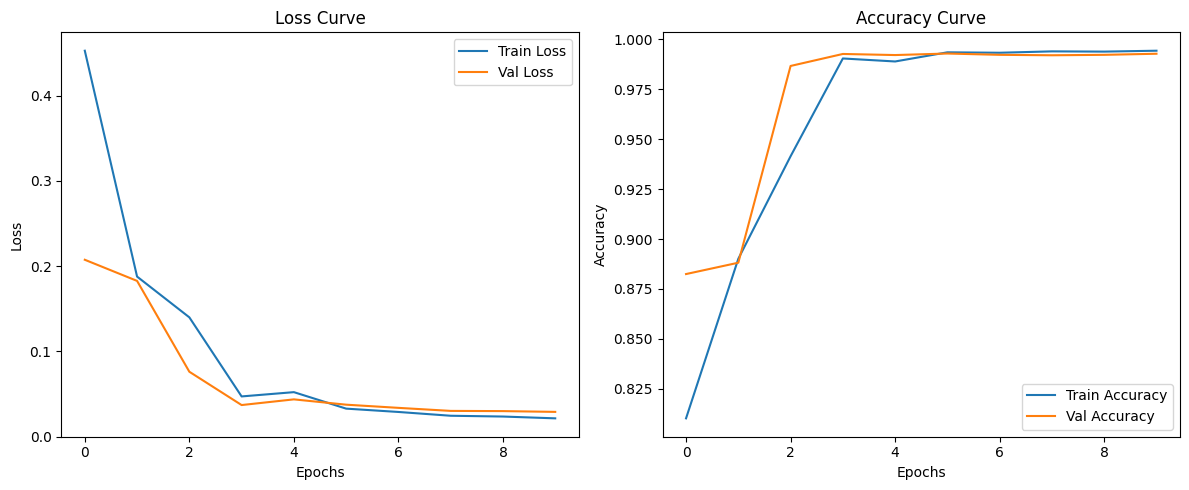

\n==================================================
Classification Report (Accuracy, Recall, F1-score)
Overall Test Accuracy: 0.9919\n
                  precision    recall  f1-score   support

          Benign     0.9903    0.9873    0.9888      3000
       DDoS_HOIC     0.9996    0.9988    0.9992      2500
  DDoS_LOIC_HTTP     1.0000    0.9980    0.9990      2500
   DoS_GoldenEye     0.9916    0.9928    0.9922      2500
        DoS_Hulk     1.0000    0.9988    0.9994      2500
DoS_SlowHTTPTest     1.0000    0.9896    0.9948      2500
   DoS_Slowloris     0.9828    0.9828    0.9828      2500
  FTP_BruteForce     0.9956    0.9876    0.9916      2500
  SSH_Bruteforce     0.9684    0.9924    0.9802      2500

        accuracy                         0.9919     23000
       macro avg     0.9920    0.9920    0.9920     23000
    weighted avg     0.9920    0.9919    0.9919     23000

\n==================================================
Plotting ROC Curve...


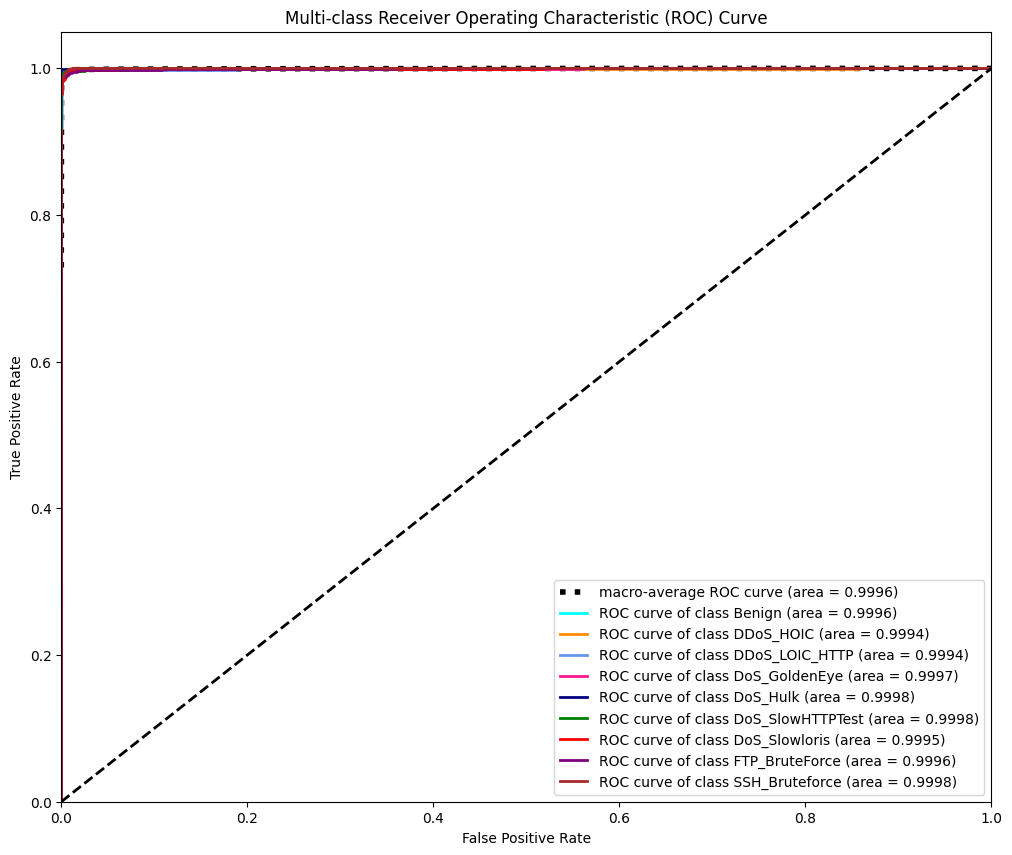

In [7]:
# 重新載入訓練過程中儲存的最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 使用測試集進行最終評估
test_loss, test_acc, test_preds, test_trues, test_probs = eval_model(test_loader)

# 獲取類別標籤
class_labels = list(dataset.class_map.keys())
num_classes = len(class_labels)

# ================================================================
# 1. 學習曲線 (Learning Curve) - Loss & Accuracy
# ================================================================
print("plotting learning curve...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# ================================================================
# 2. 分類報告 (Classification Report) - Accuracy, Recall, F1-score
# ================================================================
print("\\n" + "="*50)
print("Classification Report (Accuracy, Recall, F1-score)")
print("="*50)
print(f"Overall Test Accuracy: {test_acc:.4f}\\n")
# target_names 對應到標籤名稱
print(classification_report(test_trues, test_preds, target_names=class_labels, digits=4))


# ================================================================
# 3. ROC 曲線 (ROC Curve)
# ================================================================
print("\\n" + "="*50)
print("Plotting ROC Curve...")
print("="*50)

# 將真實標籤進行 one-hot 編碼
y_test_bin = label_binarize(test_trues, classes=list(range(num_classes)))
y_score = np.array(test_probs)

# 計算每個類別的 ROC 曲線和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 計算宏平均 (macro-average) ROC 曲線和 AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 繪製所有類別的 ROC 曲線
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'gray'])

# 繪製宏平均 ROC 曲線
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.4f})',
         color='black', linestyle=':', linewidth=4)

# 繪製每個類別的 ROC 曲線
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 5. 繪圖與混淆矩陣

### 注意

使用下面這一個 Cell 的時候需要將 TestSet 換成開放測試集會比較好。

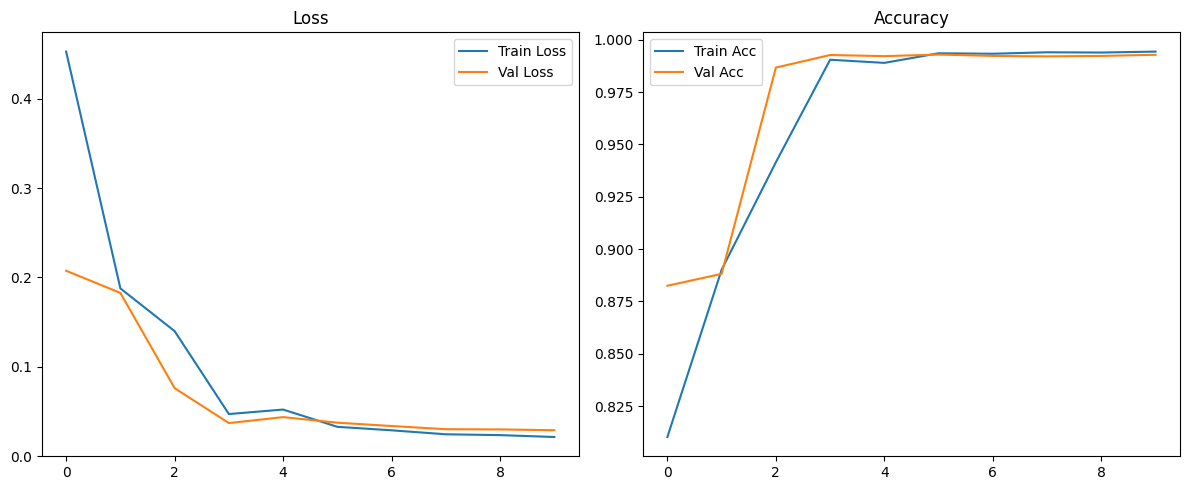

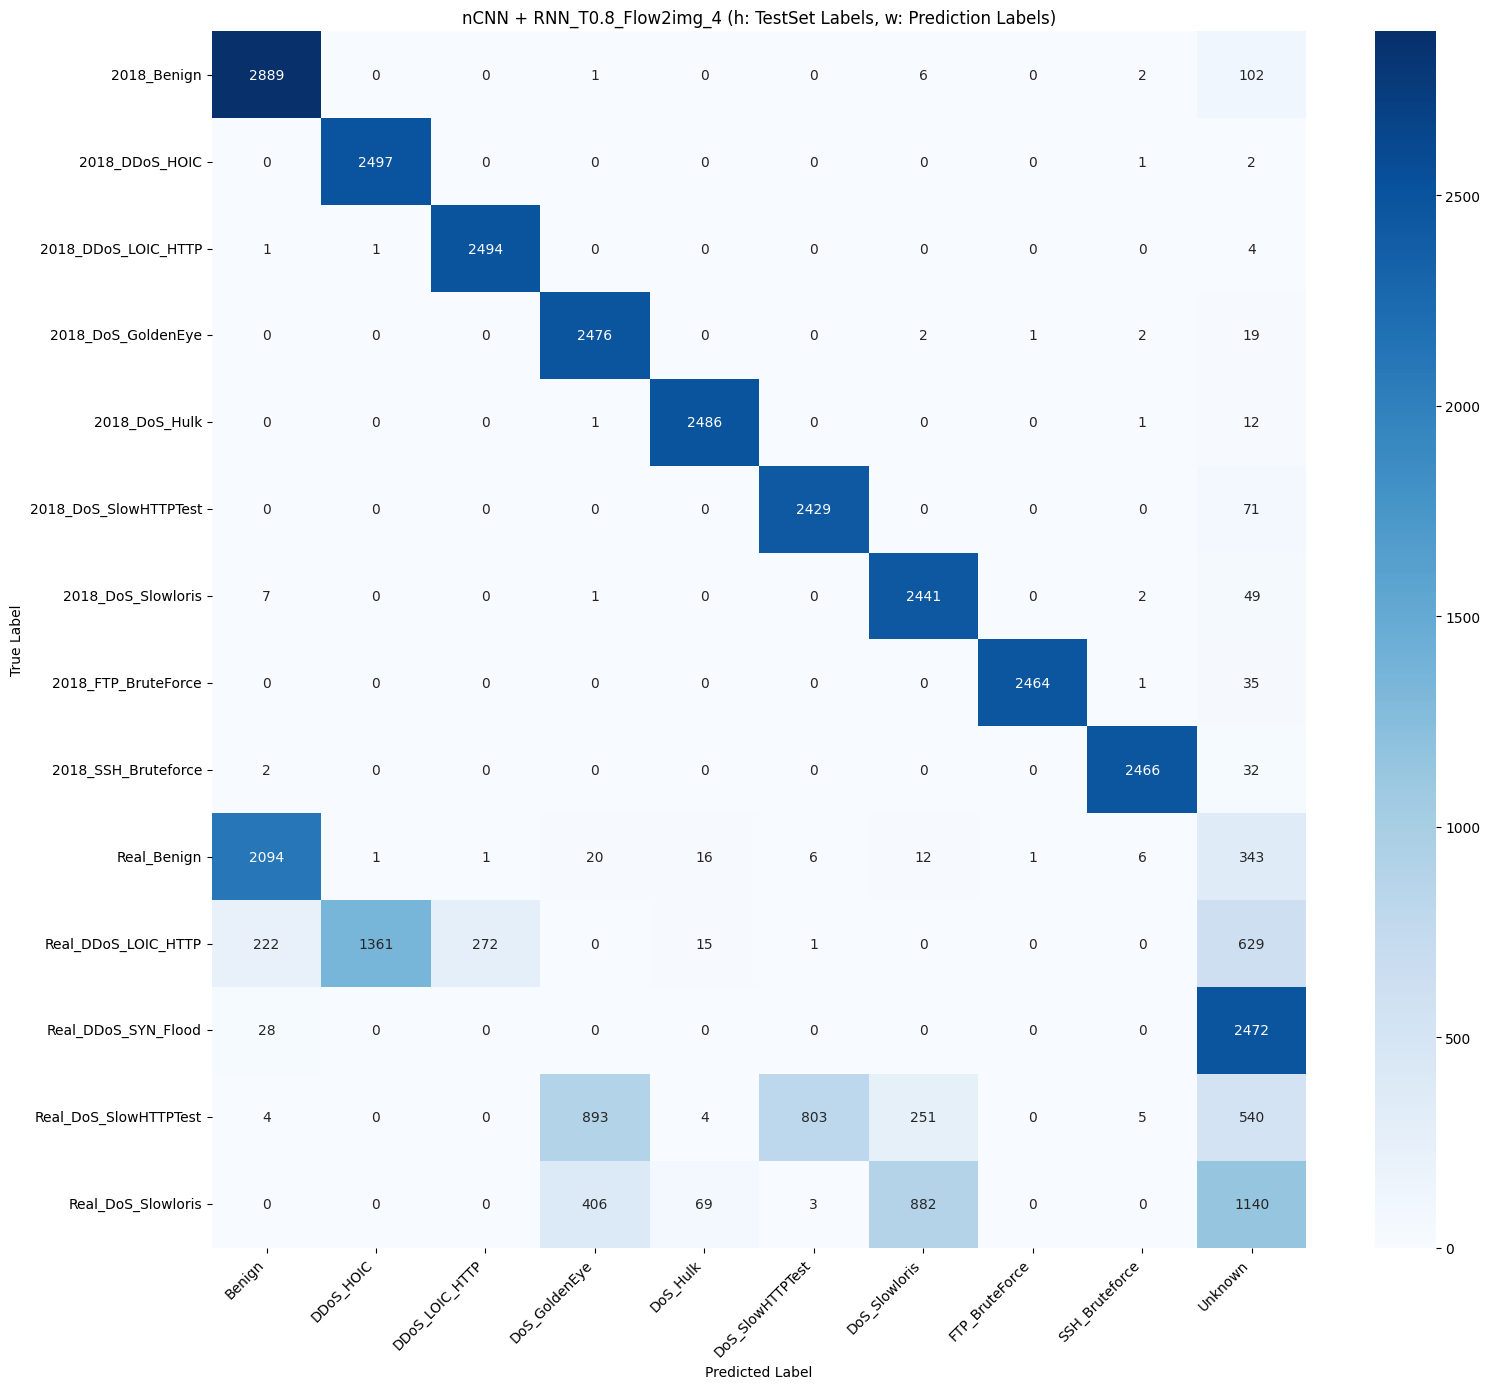

In [13]:
# 繪製 Loss & Accuracy 曲線
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

# 繪製混淆矩陣
#重新載入訓練過程中儲存的最佳模型
#確保您有執行過訓練迴圈並且 'best_model.pth' 已儲存
model.load_state_dict(torch.load('best_model.pth'))

#定義信心閾值
CONF_THRESHOLD = 0.8

##橫軸 (w): 模型的預測標籤 = 訓練時的已知類別 + "Unknown"
pred_labels = list(dataset.class_map.keys())
pred_labels.append('Unknown')

#縱軸 (h): 測試集的所有真實標籤
#我們需要一個排序過的字典，以確保標籤和索引對應
true_label_map = dict(sorted(testset.class_map.items(), key=lambda item: item[1]))
true_labels = list(true_label_map.keys())

#獲取預測結果
#已知類別的數量由 dataset (訓練資料) 決定
num_known_classes = len(dataset.class_map)
preds, trues = evaluate_open_set(test_loader, num_known_classes, threshold=CONF_THRESHOLD)

#生成並 "裁剪" 混淆矩陣
#sklearn.metrics.confusion_matrix 會生成一個方陣，其大小取決於 trues 和 preds 中的最大索引值。
#這會導致矩陣包含我們不需要的空白行或列。
#因此，我們生成它，然後立即將其裁剪成我們需要的準確形狀。
cm_full = confusion_matrix(trues, preds)

#我們的矩陣形狀應該是: (測試集真實標籤數) x (模型預測標籤數)
num_true_labels = len(true_labels)
num_pred_labels = len(pred_labels)

#進行裁剪
cm = cm_full[:num_true_labels, :num_pred_labels]

#繪製客製化的混淆矩陣
plt.figure(figsize=(16, 14)) # 可能需要更大的畫布
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pred_labels, # 橫軸標籤
            yticklabels=true_labels)  # 縱軸標籤
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'nCNN + RNN_T{CONF_THRESHOLD}_Flow2img_4 (h: TestSet Labels, w: Prediction Labels)')
#旋轉橫軸標籤，避免重疊
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # 自動調整佈局
plt.show()

In [9]:
# 儲存模型到本地中
save_path = Path(f"Final_Compare/Flow2img_4/nCNN+RNN/n{n_pkts}_m{m_bytes}_")
save_path.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), f"{save_path}/nCNN_RNN_n{n_pkts}_m{m_bytes}_inception.pth")
torch.save(model, f"{save_path}/nCNN_RNN_complete_model_n{n_pkts}_m{m_bytes}_.pth")

> [!note] 程式執行結束後，目前上面的混淆矩陣以及 notebook 並未存檔，如有需要，請自行存檔。